In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Base URL (ODI batting stats, page 1)
base_url = "https://stats.espncricinfo.com/ci/engine/stats/index.html?class=2;template=results;type=batting"

# Set a large number (we’ll stop when no more tables are found)
max_pages = 100  

all_data = []
headers = None  # store column headers once

for page in range(1, max_pages + 1):
    # Construct URL with page number
    if page == 1:
        url = base_url
    else:
        url = base_url + f";page={page}"

    print(f"Fetching page {page} ...")
    response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})

    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        tables = soup.find_all("table", class_="engineTable")

        # Stats table usually at index 2
        if len(tables) < 3:
            print(f"ERROR! No stats table found on page {page} → stopping.")
            break

        table = tables[2]

        # Extract headers only once (from first valid page)
        if headers is None:
            headers = [header.text.strip() for header in table.find_all("th")]

        # Extract rows
        rows = []
        for row in table.find_all("tr")[1:]:
            cols = row.find_all("td")
            if cols:
                rows.append([col.text.strip() for col in cols])

        # If no rows, stop (end of data)
        if not rows:
            print(f"ERROR! No data rows on page {page} → stopping.")
            break

        all_data.extend(rows)
    else:
        print(f"ERROR! Failed to retrieve page {page} (status {response.status_code})")
        break

# Build DataFrame
df = pd.DataFrame(all_data, columns=headers)

# Save to CSV
df.to_csv("all_batsman_records.csv", index=False, encoding="utf-8-sig")
print(f"\n Done! Extracted {len(df)} rows in total.")
print("Saved to all_batsman_records.csv")


Fetching page 1 ...
Fetching page 2 ...
Fetching page 3 ...
Fetching page 4 ...
Fetching page 5 ...
Fetching page 6 ...
Fetching page 7 ...
Fetching page 8 ...
Fetching page 9 ...
Fetching page 10 ...
Fetching page 11 ...
Fetching page 12 ...
Fetching page 13 ...
Fetching page 14 ...
Fetching page 15 ...
Fetching page 16 ...
Fetching page 17 ...
Fetching page 18 ...
Fetching page 19 ...
Fetching page 20 ...
Fetching page 21 ...
Fetching page 22 ...
Fetching page 23 ...
Fetching page 24 ...
Fetching page 25 ...
Fetching page 26 ...
Fetching page 27 ...
Fetching page 28 ...
Fetching page 29 ...
Fetching page 30 ...
Fetching page 31 ...
Fetching page 32 ...
Fetching page 33 ...
Fetching page 34 ...
Fetching page 35 ...
Fetching page 36 ...
Fetching page 37 ...
Fetching page 38 ...
Fetching page 39 ...
Fetching page 40 ...
Fetching page 41 ...
Fetching page 42 ...
Fetching page 43 ...
Fetching page 44 ...
Fetching page 45 ...
Fetching page 46 ...
Fetching page 47 ...
Fetching page 48 ...
F

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

#######################
# 1. Load & Clean Data
#######################
df = pd.read_csv("all_batsman_records.csv")

# Drop the unwanted column
df = df.drop(columns=["Unnamed: 13"], errors="ignore")

# Clean HS column (remove '*' and convert to int)
df["HS"] = df["HS"].str.replace("*", "", regex=False)
df["HS"] = pd.to_numeric(df["HS"], errors="coerce")

# Convert other numeric columns
numeric_cols = ["Mat", "Inns", "NO", "Runs", "Ave", "BF", "SR", "100", "50", "0"]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

print("Data cleaned successfully!")
print(df.info())
print(df.head())

#######################
# 2. Basic Exploration
#######################

# Total number of players
print(f"\nTotal players: {df.shape[0]}")

# Top 10 run scorers
print("\n Top 10 Run Scorers:")
print(df.sort_values("Runs", ascending=False)[["Player", "Runs"]].head(10))

# Top 10 by Average (min 50 innings)
print("\n Top 10 by Batting Average (min 50 innings):")
print(df[df["Inns"] >= 50].sort_values("Ave", ascending=False)[["Player", "Inns", "Ave"]].head(10))

# Top 10 by Strike Rate (min 500 balls faced)
print("\n Top 10 by Strike Rate (min 500 BF):")
print(df[df["BF"] >= 500].sort_values("SR", ascending=False)[["Player", "BF", "SR"]].head(10))

#######################
# 3. Save Cleaned Data
#######################
df.to_csv("cleaned_player_records.csv", index=False)
print("\n Cleaned dataset saved as cleaned_player_records.csv")

Data cleaned successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3069 entries, 0 to 3068
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  3069 non-null   object 
 1   Span    3069 non-null   object 
 2   Mat     3069 non-null   int64  
 3   Inns    2961 non-null   float64
 4   NO      2961 non-null   float64
 5   Runs    2961 non-null   float64
 6   HS      2961 non-null   float64
 7   Ave     2814 non-null   float64
 8   BF      2961 non-null   float64
 9   SR      2948 non-null   float64
 10  100     2961 non-null   float64
 11  50      2961 non-null   float64
 12  0       2961 non-null   float64
dtypes: float64(10), int64(1), object(2)
memory usage: 311.8+ KB
None
                        Player       Span  Mat   Inns    NO     Runs     HS  \
0           SR Tendulkar (IND)  1989-2012  463  452.0  41.0  18426.0  200.0   
1  KC Sangakkara (Asia/ICC/SL)  2000-2015  404  380.0  41.0  14234.0  169.0   
2   

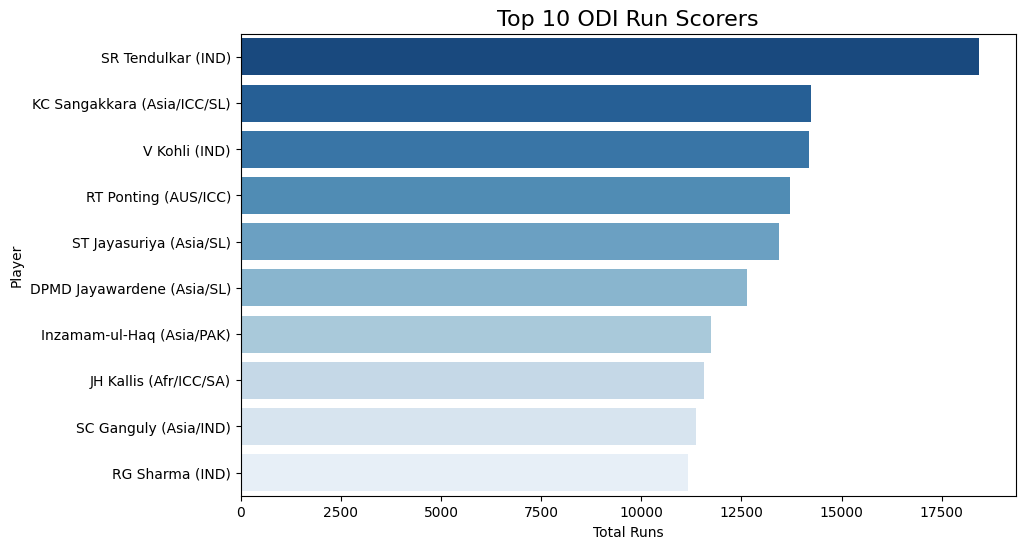

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load batting dataset
batting = pd.read_csv("all_batsman_records.csv")

# Convert Runs to numeric
batting["Runs"] = pd.to_numeric(batting["Runs"], errors="coerce")
batting = batting.dropna(subset=["Runs"])

# Pick top 10 run scorers
top_runs = batting.sort_values(by="Runs", ascending=False).head(10)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=top_runs, x="Runs", y="Player", hue="Player", palette="Blues_r", dodge=False, legend=False)
plt.title("Top 10 ODI Run Scorers", fontsize=16)
plt.xlabel("Total Runs")
plt.ylabel("Player")
plt.show()


In [17]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Base URL (ODI bowling stats, page 1)
base_url = "https://stats.espncricinfo.com/ci/engine/stats/index.html?class=2;template=results;type=bowling"

# Set a large number (we’ll stop when no more tables are found)
max_pages = 100  

all_data = []
headers = None  # store column headers once

for page in range(1, max_pages + 1):
    # Construct URL with page number
    if page == 1:
        url = base_url
    else:
        url = base_url + f";page={page}"

    print(f"Fetching page {page} ...")
    response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})

    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        tables = soup.find_all("table", class_="engineTable")

        # Stats table usually at index 2
        if len(tables) < 3:
            print(f"ERROR! No stats table found on page {page} → stopping.")
            break

        table = tables[2]

        # Extract headers only once (from first valid page)
        if headers is None:
            headers = [header.text.strip() for header in table.find_all("th")]

        # Extract rows
        rows = []
        for row in table.find_all("tr")[1:]:
            cols = row.find_all("td")
            if cols:
                rows.append([col.text.strip() for col in cols])

        # If no rows, stop (end of data)
        if not rows:
            print(f"ERROR! No data rows on page {page} → stopping.")
            break

        all_data.extend(rows)
    else:
        print(f"ERROR! Failed to retrieve page {page} (status {response.status_code})")
        break

# Build DataFrame
df = pd.DataFrame(all_data, columns=headers)

# Save to CSV
df.to_csv("all_bowler_records.csv", index=False, encoding="utf-8-sig")
print(f"\n Done! Extracted {len(df)} rows in total.")
print("Saved to all_bowler_records.csv")


Fetching page 1 ...
Fetching page 2 ...
Fetching page 3 ...
Fetching page 4 ...
Fetching page 5 ...
Fetching page 6 ...
Fetching page 7 ...
Fetching page 8 ...
Fetching page 9 ...
Fetching page 10 ...
Fetching page 11 ...
Fetching page 12 ...
Fetching page 13 ...
Fetching page 14 ...
Fetching page 15 ...
Fetching page 16 ...
Fetching page 17 ...
Fetching page 18 ...
Fetching page 19 ...
Fetching page 20 ...
Fetching page 21 ...
Fetching page 22 ...
Fetching page 23 ...
Fetching page 24 ...
Fetching page 25 ...
Fetching page 26 ...
Fetching page 27 ...
Fetching page 28 ...
Fetching page 29 ...
Fetching page 30 ...
Fetching page 31 ...
Fetching page 32 ...
Fetching page 33 ...
Fetching page 34 ...
Fetching page 35 ...
Fetching page 36 ...
Fetching page 37 ...
Fetching page 38 ...
Fetching page 39 ...
Fetching page 40 ...
Fetching page 41 ...
Fetching page 42 ...
Fetching page 43 ...
Fetching page 44 ...
Fetching page 45 ...
Fetching page 46 ...
Fetching page 47 ...
Fetching page 48 ...
F

📊 Correlation Results (All Bowlers):
  Metric  Correlation (r)       p-value
0    Ave        -0.210845  1.154068e-20
1   Econ        -0.161790  1.089793e-12
2     SR        -0.180751  1.636382e-15
3      4         0.855524  0.000000e+00
4      5         0.748282  0.000000e+00


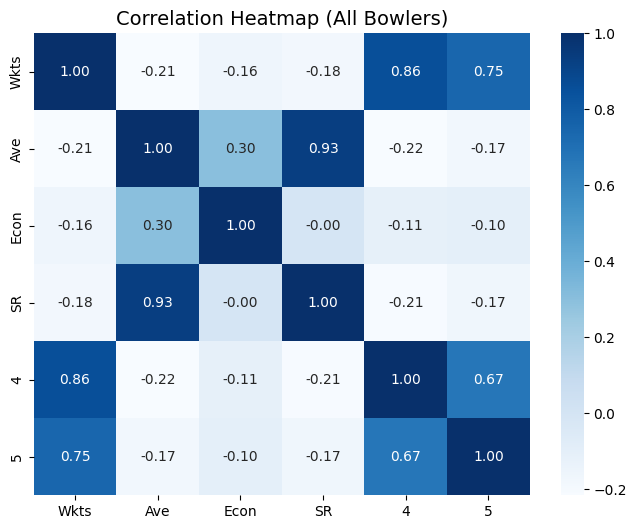

In [23]:
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

# Load your bowling dataset
df = pd.read_csv("all_bowler_records.csv")

# Convert relevant columns to numeric
numeric_cols = ["Wkts", "Ave", "Econ", "SR", "4", "5"]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop rows with missing values in these columns
df_clean = df[numeric_cols].dropna()

# Correlation analysis (Pearson r + p-value)
results = []
for col in ["Ave", "Econ", "SR", "4", "5"]:
    r, p = pearsonr(df_clean["Wkts"], df_clean[col])
    results.append({"Metric": col, "Correlation (r)": r, "p-value": p})

results_df = pd.DataFrame(results)

print("📊 Correlation Results (All Bowlers):")
print(results_df)

# Optional: Heatmap visualization
plt.figure(figsize=(8,6))
sns.heatmap(df_clean.corr(), annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Heatmap (All Bowlers)", fontsize=14)
plt.show()


In [18]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Base URL (ODI all-rounders stats, page 1)
base_url = "https://stats.espncricinfo.com/ci/engine/stats/index.html?class=2;template=results;type=allround"

# Set a large number (we’ll stop when no more tables are found)
max_pages = 100  

all_data = []
headers = None  # store column headers once

for page in range(1, max_pages + 1):
    # Construct URL with page number
    if page == 1:
        url = base_url
    else:
        url = base_url + f";page={page}"

    print(f"Fetching page {page} ...")
    response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})

    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        tables = soup.find_all("table", class_="engineTable")

        # Stats table usually at index 2
        if len(tables) < 3:
            print(f"ERROR! No stats table found on page {page} → stopping.")
            break

        table = tables[2]

        # Extract headers only once (from first valid page)
        if headers is None:
            headers = [header.text.strip() for header in table.find_all("th")]

        # Extract rows
        rows = []
        for row in table.find_all("tr")[1:]:
            cols = row.find_all("td")
            if cols:
                rows.append([col.text.strip() for col in cols])

        # If no rows, stop (end of data)
        if not rows:
            print(f"ERROR! No data rows on page {page} → stopping.")
            break

        all_data.extend(rows)
    else:
        print(f"ERROR! Failed to retrieve page {page} (status {response.status_code})")
        break

# Build DataFrame
df = pd.DataFrame(all_data, columns=headers)

# Save to CSV
df.to_csv("all_allrounder_records.csv", index=False, encoding="utf-8-sig")
print(f"\n Done! Extracted {len(df)} rows in total.")
print("Saved to all_allrounder_records.csv")


Fetching page 1 ...
Fetching page 2 ...
Fetching page 3 ...
Fetching page 4 ...
Fetching page 5 ...
Fetching page 6 ...
Fetching page 7 ...
Fetching page 8 ...
Fetching page 9 ...
Fetching page 10 ...
Fetching page 11 ...
Fetching page 12 ...
Fetching page 13 ...
Fetching page 14 ...
Fetching page 15 ...
Fetching page 16 ...
Fetching page 17 ...
Fetching page 18 ...
Fetching page 19 ...
Fetching page 20 ...
Fetching page 21 ...
Fetching page 22 ...
Fetching page 23 ...
Fetching page 24 ...
Fetching page 25 ...
Fetching page 26 ...
Fetching page 27 ...
Fetching page 28 ...
Fetching page 29 ...
Fetching page 30 ...
Fetching page 31 ...
Fetching page 32 ...
Fetching page 33 ...
Fetching page 34 ...
Fetching page 35 ...
Fetching page 36 ...
Fetching page 37 ...
Fetching page 38 ...
Fetching page 39 ...
Fetching page 40 ...
Fetching page 41 ...
Fetching page 42 ...
Fetching page 43 ...
Fetching page 44 ...
Fetching page 45 ...
Fetching page 46 ...
Fetching page 47 ...
Fetching page 48 ...
F

In [19]:
import pandas as pd

#######################
# 1. Load datasets
#######################
batting = pd.read_csv("all_batsman_records.csv")
bowling = pd.read_csv("all_bowler_records.csv")
allround = pd.read_csv("all_allrounder_records.csv")

###########################
# 2. Select useful columns
###########################
batting = batting[['Player', 'Runs', 'Ave', 'SR', '100', '50']].copy()
bowling = bowling[['Player', 'Wkts', 'Ave', 'Econ', 'SR', '5']].copy()
allround = allround.rename(columns={'Bat Av': 'Bat_Ave', 'Bowl Av': 'Bowl_Ave'})
allround = allround[['Player', 'Runs', 'Bat_Ave', 'Wkts', 'Bowl_Ave']].copy()

###########################
# 3. Clean numeric columns
###########################
for df in [batting, bowling, allround]:
    for col in df.columns:
        if col != "Player":
            df[col] = pd.to_numeric(df[col], errors="coerce")

###########################
# 4. Add Role Tag
###########################
batting['Role'] = 'Batsman'
bowling['Role'] = 'Bowler'
allround['Role'] = 'Allrounder'

###########################
# 5. Merge datasets
###########################
combined = pd.concat([batting, bowling, allround], ignore_index=True)

# Deduplication: keep one record per player
def choose_best_role(group):
    if len(group) == 1:
        return group.iloc[0]
    # Check strengths
    runs = group['Runs'].max(skipna=True)
    wkts = group['Wkts'].max(skipna=True) if 'Wkts' in group else 0

    if pd.notna(runs) and runs > 5000 and (pd.isna(wkts) or wkts < 100):
        return group[group['Role'] == 'Batsman'].iloc[0]
    elif pd.notna(wkts) and wkts > 200 and (pd.isna(runs) or runs < 3000):
        return group[group['Role'] == 'Bowler'].iloc[0]
    else:
        return group[group['Role'] == 'Allrounder'].iloc[0] if 'Allrounder' in group['Role'].values else group.iloc[0]

deduped = combined.groupby("Player", group_keys=False).apply(choose_best_role).reset_index(drop=True)
###########################
# 6. Pick Best XI
###########################
best_batsmen = deduped[deduped['Role'] == 'Batsman'].sort_values(by='Runs', ascending=False).head(5)
best_bowlers = deduped[deduped['Role'] == 'Bowler'].sort_values(by='Wkts', ascending=False).head(4)

# Score allrounders
allr = deduped[deduped['Role'] == 'Allrounder'].copy()
allr['Score'] = allr['Runs'].fillna(0) * 0.5 + allr['Wkts'].fillna(0) * 20
best_allrounders = allr.sort_values(by='Score', ascending=False).head(2)

best_xi = pd.concat([best_batsmen, best_allrounders, best_bowlers], ignore_index=True)

###########################
# 7. Save Results
###########################
best_xi.to_csv("best_playing_11.csv", index=False)

print("\n Best Playing XI (deduplicated):\n")
print(best_xi[['Player','Role']])
print("\n Saved to best_playing_11.csv")



 Best Playing XI (deduplicated):

                         Player        Role
0   KC Sangakkara (Asia/ICC/SL)     Batsman
1                 V Kohli (IND)     Batsman
2          RT Ponting (AUS/ICC)     Batsman
3    DPMD Jayawardene (Asia/SL)     Batsman
4     Inzamam-ul-Haq (Asia/PAK)     Batsman
5       ST Jayasuriya (Asia/SL)  Allrounder
6            SR Tendulkar (IND)  Allrounder
7   M Muralidaran (Asia/ICC/SL)      Bowler
8            Waqar Younis (PAK)      Bowler
9          WPUJC Vaas (Asia/SL)      Bowler
10         GD McGrath (AUS/ICC)      Bowler

 Saved to best_playing_11.csv


C:\Users\devan\AppData\Local\Temp\ipykernel_26092\634838908.py:53: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  deduped = combined.groupby("Player", group_keys=False).apply(choose_best_role).reset_index(drop=True)


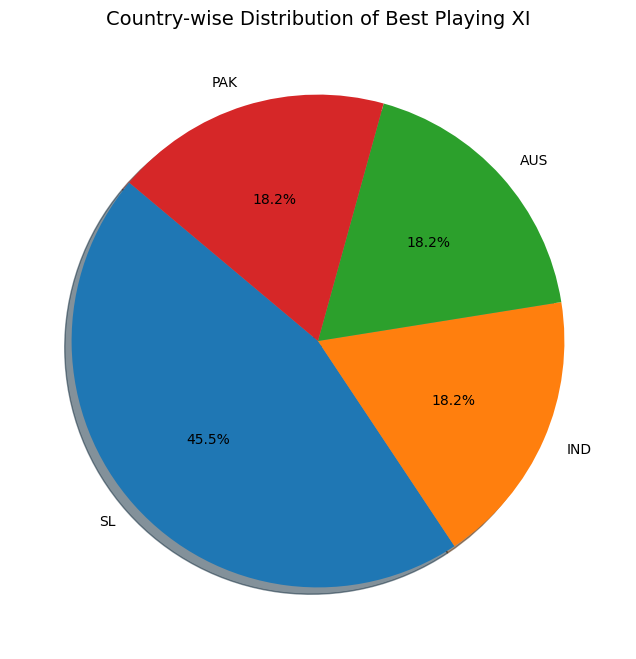

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load Best XI data
best_xi = pd.read_csv("best_playing_11.csv")

# Extract country part
best_xi["Country"] = best_xi["Player"].str.extract(r"\((.*?)\)")

# Clean country names: remove "Asia" and "ICC"
def clean_country(entry):
    if pd.isna(entry):
        return None
    parts = entry.split("/")
    # Keep the first valid country that is not Asia/ICC
    for p in parts:
        if p not in ["Asia", "ICC"]:
            return p
    return parts[-1]  # fallback

best_xi["Country"] = best_xi["Country"].apply(clean_country)

# Count players by country
country_counts = best_xi["Country"].value_counts()

# Plot Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(
    country_counts,
    labels=country_counts.index,
    autopct="%1.1f%%",
    startangle=140,
    shadow=True
)

plt.title("Country-wise Distribution of Best Playing XI", fontsize=14)
plt.show()

